In [1]:
#basic package
import json
import tqdm
import os
import numpy as np
import glob
import pandas as pd
import sys
import shutil
import time
import datetime as dt
import itertools
import time
import re
from collections import Counter
from collections import defaultdict
import operator
import math
import functools
import collections

#plot
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
PACKAGE_PARENT = '../'
SCRIPT_DIR = os.path.dirname(os.path.realpath(os.path.join(os.getcwd(), os.path.expanduser('__file__'))))
sys.path.append(os.path.normpath(os.path.join(SCRIPT_DIR, PACKAGE_PARENT)))
from UTILS import kmeans_clustering, sampen, chi2_distance
import config_origins as config

C:\Users\camil\anaconda3\lib\site-packages\scipy\sparse\sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


2


In [3]:
path_performance = config.path_performance
path_dataoutput = config.path_dataoutput
dico_pen_tr = config.dico_pen_tr
pal_treat = config.pal_treat
birth_date = config.birth_date
path_extracted_data = config.path_extracted_data
path_performance_visual = os.path.join(path_dataoutput,'performance') 
#create a director if not existing
if not os.path.exists(path_performance_visual):
    os.makedirs(path_performance_visual)
path_performance_visual

'G:\\VPHI\\Welfare\\2- Research Projects\\OFHE2.OriginsE2\\DataOutput\\performance'

In [4]:
path_performance

'G:\\VPHI\\Welfare\\2- Research Projects\\OFHE2.OriginsE2\\Productivity'

# Download data

In [5]:
#performance
li_df = []
for d in [str(i)+'_4_E420' for i in range(0,12)]:
    print(d)
    for v in ['('+str(i)+')' for i in range(1,21)]:
        xls = pd.ExcelFile(glob.glob(os.path.join(path_performance,d+'.xls*'))[0])
        df = pd.read_excel(xls, v, header=None)
        df = df.iloc[2:,]
        df.columns = df.iloc[0]
        df = df.drop(2, axis=0)
        df = df[~df['Vers.-Tag'].isnull()] #remove all rows that has nothing to do with the egg per day
        df['LayingPhase'] = d
        df['Pen'] = int(v[1:-1])
        if df.shape[0]!=28:
            print('ERROR: ', d, v,' have wrong shape', df.shape)
        if df.shape[1]!=15:
            print('ERROR: ', d, v,' have wrong shape', df.shape)
        df.head(2)
        li_df.append(df)
        df_test = pd.concat(li_df)
df = pd.concat(li_df)

#egg
df['Nest-eier'].fillna(0,inplace=True)
df['Tier-bestand'].fillna(0,inplace=True)
df['#eggPerTier'] = df.apply(lambda x: x['Nest-eier']/x['Tier-bestand'],axis=1)
#9 septembre 2020: 420 DOA --> ne le ~ 9 juillet 2019
df['#eggOutsideBoxPerTier'] = df.apply(lambda x: x['ver-legt']/x['Tier-bestand'],axis=1)

#death
#first fill na with 0, otherwise the sum will always be =0
df['Ab-gänge'] = df['Ab-gänge'].fillna(0)
df['Kanni-balis.'] = df['Kanni-balis.'].fillna(0)
df['Early_death'] = df['Ab-gänge']+df['Kanni-balis.']

#experiment specifics
df['DOA'] = df['Datum'].map(lambda x: (x-birth_date).days) 
df['WOA'] = df['DOA'].map(lambda x: math.ceil(x/7))
df['DIB'] = df['DOA'].map(lambda x: x-118)
df['WIB'] = df['DIB'].map(lambda x:  math.ceil(x/7))
df['level'] = df['Datum'].map(lambda x:  dt.datetime(x.year,x.month,x.day))
#for now just use our pens (one could add the other)
df = df[df['Pen'].isin([3,4,5,8,9,10,11,12,6,7])]
df['Treatment'] = df['Pen'].map(lambda x: dico_pen_tr['pen'+str(x)])
df.to_csv(os.path.join(path_performance,'egg_summary_adaptability.csv'), index=False, sep=';')

#save for stats in the daptability analysis
df.rename(columns={'Pen':'PenID'}, inplace=True)
df['#eggPerTier'] = df['#eggPerTier'].fillna(0)
df['#eggOutsideBoxPerTier'] = df['#eggOutsideBoxPerTier'].fillna(0)
print(df.shape)
df.head(3)

0_4_E420


C:\Users\camil\anaconda3\lib\site-packages\openpyxl\worksheet\header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")


1_4_E420
2_4_E420
3_4_E420
4_4_E420
5_4_E420
6_4_E420
7_4_E420
8_4_E420
9_4_E420
10_4_E420
11_4_E420


C:\Users\camil\anaconda3\lib\site-packages\pandas\core\generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


(3360, 24)


2,Datum,Vers.-Tag,Ab-gänge,Kanni-balis.,spez. Veränderung,Anfangs-Bestand,Tier-bestand,ver-legt,Nest-eier,Total,...,PenID,#eggPerTier,#eggOutsideBoxPerTier,Early_death,DOA,WOA,DIB,WIB,level,Treatment
4,2020-09-24 00:00:00,1,0,0,NaN,225,225,NaN,NaN,0,...,3,0.0,0.0,0,113,17,-5,0,2020-09-24,OFH
5,2020-09-25 00:00:00,2,0,0,NaN,225,225,NaN,NaN,0,...,3,0.0,0.0,0,114,17,-4,0,2020-09-25,OFH
6,2020-09-26 00:00:00,3,0,0,NaN,225,225,NaN,NaN,0,...,3,0.0,0.0,0,115,17,-3,0,2020-09-26,OFH


## In numbers

In [6]:
print(max(df['DOA'].tolist()))
df['Treatment_allpens'] = df['Treatment'].map(lambda x: x.split('-')[0])
#sum all the death within this two months time period
df_ = df.groupby(['Treatment_allpens', 'PenID'])['Early_death'].sum().reset_index()
display(df_)
#shows stat on the sumed early death across the 2 treatments
df_.groupby(['Treatment_allpens'])['Early_death'].describe()

448


,Treatment_allpens,PenID,Early_death
0,OFH,3,18
1,OFH,5,11
2,OFH,7,9
3,OFH,9,10
4,OFH,11,17
5,TRAN,4,15
6,TRAN,6,21
7,TRAN,8,16
8,TRAN,10,15
9,TRAN,12,14


,count,mean,std,min,25%,50%,75%,max
Treatment_allpens,,,,,,,,
OFH,5.0,13.0,4.183300,9.0,10.0,11.0,17.0,18.0
TRAN,5.0,16.2,2.774887,14.0,15.0,15.0,16.0,21.0


## In visuals

In [7]:
#small date verification
df[df['PenID']==3][['Datum','DIB']].head(50)

2,Datum,DIB
4,2020-09-24 00:00:00,-5
5,2020-09-25 00:00:00,-4
6,2020-09-26 00:00:00,-3
7,2020-09-27 00:00:00,-2
8,2020-09-28 00:00:00,-1
9,2020-09-29 00:00:00,0
10,2020-09-30 00:00:00,1
11,2020-10-01 00:00:00,2
12,2020-10-02 00:00:00,3
13,2020-10-03 00:00:00,4


## Eggs

##### adaptability (early days & only the 8 studied pens)

In [27]:
df_adapt = df[(df['level']>config.date_populationday) & \
              (df['level']<=config.max_date_adaptability)& \
              (df['PenID'].isin([3,4,5,8,9,10,11,12]))][['DOA','PenID','Treatment','Early_death',
                                                                                                      '#eggPerTier','WOA','#eggOutsideBoxPerTier',
                                                                                                      'DIB','level']].copy()
df_adapt.to_csv(os.path.join(path_performance_visual,'STATPerformance10pensdoa119-172.csv'), index=False, sep=';')
df_adapt = df_adapt.reset_index(drop=True) #or downgrade seaborn
print(df_adapt.shape)
df_adapt.head(3)

(432, 9)


2,DOA,PenID,Treatment,Early_death,#eggPerTier,WOA,#eggOutsideBoxPerTier,DIB,level
0,119,3,OFH,0.0,0.0,17,0.0,1,2020-09-30
1,120,3,OFH,0.0,0.0,18,0.0,2,2020-10-01
2,121,3,OFH,0.0,0.0,18,0.0,3,2020-10-02


In [28]:
df_adapt[df_adapt['level']==dt.datetime(2020,11,13)] #time light schedule stable

2,DOA,PenID,Treatment,Early_death,#eggPerTier,WOA,#eggOutsideBoxPerTier,DIB,level
198,163,3,OFH,0.0,1.000000,24,0.004608,45,2020-11-13
226,163,4,TRAN,0.0,0.949772,24,0.000000,45,2020-11-13
254,163,5,OFH,1.0,0.968182,24,0.000000,45,2020-11-13
282,163,8,TRAN,0.0,0.939252,24,0.000000,45,2020-11-13
310,163,9,OFH,0.0,1.036697,24,0.004587,45,2020-11-13
338,163,10,TRAN,0.0,0.944954,24,0.000000,45,2020-11-13
366,163,11,OFH,0.0,1.009174,24,0.000000,45,2020-11-13
394,163,12,TRAN,0.0,0.922374,24,0.004566,45,2020-11-13


2,Datum,Vers.-Tag,Ab-gänge,Kanni-balis.,spez. Veränderung,Anfangs-Bestand,Tier-bestand,ver-legt,Nest-eier,Total,...,#eggPerTier,#eggOutsideBoxPerTier,Early_death,DOA,WOA,DIB,WIB,level,Treatment,Treatment_allpens
4,2020-09-24 00:00:00,1,0,0,NaN,225,225,NaN,NaN,0,...,0.0,0.0,0.0,113,17,-5,0,2020-09-24,OFH,OFH
5,2020-09-25 00:00:00,2,0,0,NaN,225,225,NaN,NaN,0,...,0.0,0.0,0.0,114,17,-4,0,2020-09-25,OFH,OFH


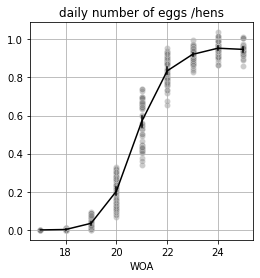

2,Datum,Vers.-Tag,Ab-gänge,Kanni-balis.,spez. Veränderung,Anfangs-Bestand,Tier-bestand,ver-legt,Nest-eier,Total,...,#eggPerTier,#eggOutsideBoxPerTier,Early_death,DOA,WOA,DIB,WIB,level,Treatment,Treatment_allpens
4,2020-09-24 00:00:00,1,0,0,NaN,225,225,NaN,NaN,0,...,0.0,0.0,0.0,113,17,-5,0,2020-09-24,OFH,OFH
5,2020-09-25 00:00:00,2,0,0,NaN,225,225,NaN,NaN,0,...,0.0,0.0,0.0,114,17,-4,0,2020-09-25,OFH,OFH


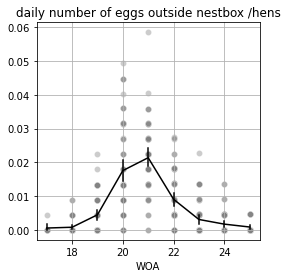

2,Datum,Vers.-Tag,Ab-gänge,Kanni-balis.,spez. Veränderung,Anfangs-Bestand,Tier-bestand,ver-legt,Nest-eier,Total,...,#eggPerTier,#eggOutsideBoxPerTier,Early_death,DOA,WOA,DIB,WIB,level,Treatment,Treatment_allpens
4,2020-09-24 00:00:00,1,0,0,NaN,225,225,NaN,NaN,0,...,0.0,0.0,0.0,113,17,-5,0,2020-09-24,OFH,OFH
5,2020-09-25 00:00:00,2,0,0,NaN,225,225,NaN,NaN,0,...,0.0,0.0,0.0,114,17,-4,0,2020-09-25,OFH,OFH


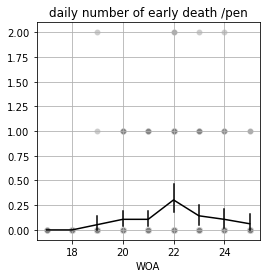

In [29]:
dico_title = {'#eggPerTier':'daily number of eggs /hens', 
              '#eggOutsideBoxPerTier': 'daily number of eggs outside nestbox /hens', 
              'Early_death':'daily number of early death /pen'}
for v in ['#eggPerTier', '#eggOutsideBoxPerTier', 'Early_death']:
    plt.figure(figsize=(4,4))
    plt.grid()
    ax = plt.plot()
    df[v] = df[v].astype(float)
    display(df.head(2))
    sns.lineplot(x="WOA", y=v, data=df_adapt, estimator=np.mean, err_style="bars", ci=95, color='black');
    sns.scatterplot(x="WOA", y=v, data=df_adapt, alpha=0.4, color='grey');
    plt.ylabel('')
    plt.title(dico_title[v])
    plt.savefig(os.path.join(path_performance_visual,v+'_WOA_adaptability.png'),dpi=300,format='png',bbox_inches='tight')
    plt.show();

2,Datum,Vers.-Tag,Ab-gänge,Kanni-balis.,spez. Veränderung,Anfangs-Bestand,Tier-bestand,ver-legt,Nest-eier,Total,...,#eggPerTier,#eggOutsideBoxPerTier,Early_death,DOA,WOA,DIB,WIB,level,Treatment,Treatment_allpens
4,2020-09-24 00:00:00,1,0,0,NaN,225,225,NaN,NaN,0,...,0.0,0.0,0.0,113,17,-5,0,2020-09-24,OFH,OFH
5,2020-09-25 00:00:00,2,0,0,NaN,225,225,NaN,NaN,0,...,0.0,0.0,0.0,114,17,-4,0,2020-09-25,OFH,OFH


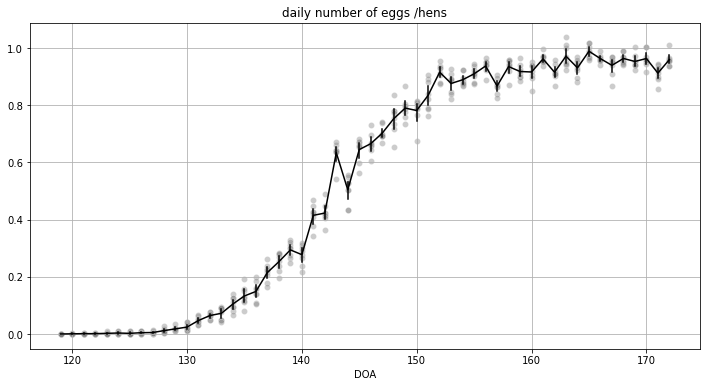

2,Datum,Vers.-Tag,Ab-gänge,Kanni-balis.,spez. Veränderung,Anfangs-Bestand,Tier-bestand,ver-legt,Nest-eier,Total,...,#eggPerTier,#eggOutsideBoxPerTier,Early_death,DOA,WOA,DIB,WIB,level,Treatment,Treatment_allpens
4,2020-09-24 00:00:00,1,0,0,NaN,225,225,NaN,NaN,0,...,0.0,0.0,0.0,113,17,-5,0,2020-09-24,OFH,OFH
5,2020-09-25 00:00:00,2,0,0,NaN,225,225,NaN,NaN,0,...,0.0,0.0,0.0,114,17,-4,0,2020-09-25,OFH,OFH


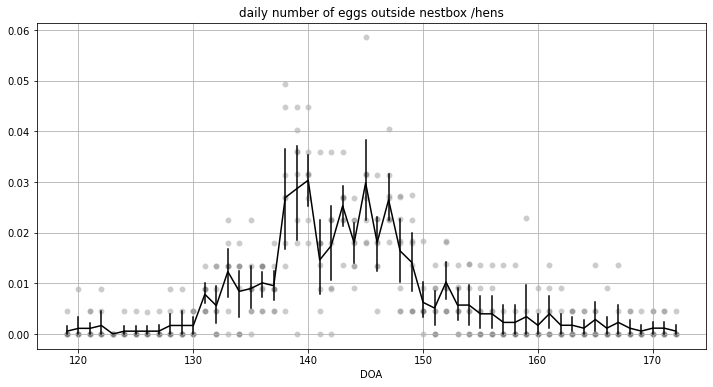

2,Datum,Vers.-Tag,Ab-gänge,Kanni-balis.,spez. Veränderung,Anfangs-Bestand,Tier-bestand,ver-legt,Nest-eier,Total,...,#eggPerTier,#eggOutsideBoxPerTier,Early_death,DOA,WOA,DIB,WIB,level,Treatment,Treatment_allpens
4,2020-09-24 00:00:00,1,0,0,NaN,225,225,NaN,NaN,0,...,0.0,0.0,0.0,113,17,-5,0,2020-09-24,OFH,OFH
5,2020-09-25 00:00:00,2,0,0,NaN,225,225,NaN,NaN,0,...,0.0,0.0,0.0,114,17,-4,0,2020-09-25,OFH,OFH


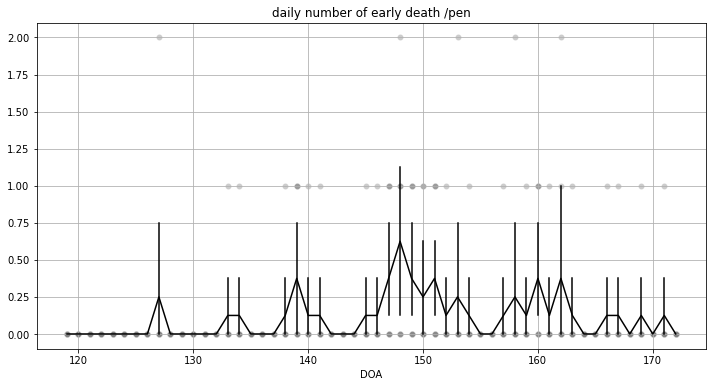

In [30]:
for v in ['#eggPerTier', '#eggOutsideBoxPerTier', 'Early_death']:
    plt.figure(figsize=(12,6))
    plt.grid()
    ax = plt.plot()
    df[v] = df[v].astype(float)
    display(df.head(2))
    sns.lineplot(x="DOA", y=v, data=df_adapt, estimator=np.mean, err_style="bars", ci=95, color='black');
    sns.scatterplot(x="DOA", y=v, data=df_adapt, alpha=0.4, color='grey');
    plt.ylabel('')
    plt.title(dico_title[v])
    plt.savefig(os.path.join(path_performance_visual,v+'_DOA_adaptability.png'),dpi=300,format='png',bbox_inches='tight')
    plt.show();

##### all with treatment

In [31]:
df_treatment = df[(df['level']>config.date_populationday)].copy()
df_treatment[['DOA','PenID','Treatment','Early_death','#eggPerTier','WOA','#eggOutsideBoxPerTier','DIB']].to_csv(os.path.join(path_performance_visual,'STATPerformance10pensdoaallBarn4.csv'), index=False, sep=';')
df_treatment = df_treatment.reset_index() #or downgrade seaborn
print(df_treatment.shape)
df_treatment.head(3)

(3300, 26)


2,index,Datum,Vers.-Tag,Ab-gänge,Kanni-balis.,spez. Veränderung,Anfangs-Bestand,Tier-bestand,ver-legt,Nest-eier,...,#eggPerTier,#eggOutsideBoxPerTier,Early_death,DOA,WOA,DIB,WIB,level,Treatment,Treatment_allpens
0,10,2020-09-30 00:00:00,7,0,0,NaN,225,225,NaN,NaN,...,0.0,0.0,0.0,119,17,1,1,2020-09-30,OFH,OFH
1,11,2020-10-01 00:00:00,8,0,0,NaN,225,225,NaN,NaN,...,0.0,0.0,0.0,120,18,2,1,2020-10-01,OFH,OFH
2,12,2020-10-02 00:00:00,9,0,0,NaN,225,225,NaN,NaN,...,0.0,0.0,0.0,121,18,3,1,2020-10-02,OFH,OFH


2,Datum,Vers.-Tag,Ab-gänge,Kanni-balis.,spez. Veränderung,Anfangs-Bestand,Tier-bestand,ver-legt,Nest-eier,Total,...,#eggPerTier,#eggOutsideBoxPerTier,Early_death,DOA,WOA,DIB,WIB,level,Treatment,Treatment_allpens
4,2020-09-24 00:00:00,1,0,0,NaN,225,225,NaN,NaN,0,...,0.0,0.0,0.0,113,17,-5,0,2020-09-24,OFH,OFH
5,2020-09-25 00:00:00,2,0,0,NaN,225,225,NaN,NaN,0,...,0.0,0.0,0.0,114,17,-4,0,2020-09-25,OFH,OFH


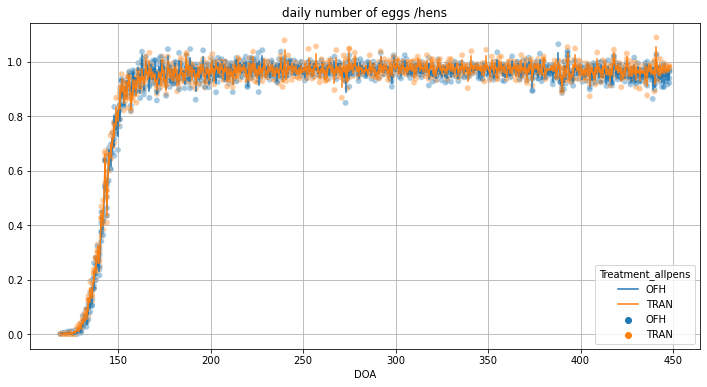

2,Datum,Vers.-Tag,Ab-gänge,Kanni-balis.,spez. Veränderung,Anfangs-Bestand,Tier-bestand,ver-legt,Nest-eier,Total,...,#eggPerTier,#eggOutsideBoxPerTier,Early_death,DOA,WOA,DIB,WIB,level,Treatment,Treatment_allpens
4,2020-09-24 00:00:00,1,0,0,NaN,225,225,NaN,NaN,0,...,0.0,0.0,0.0,113,17,-5,0,2020-09-24,OFH,OFH
5,2020-09-25 00:00:00,2,0,0,NaN,225,225,NaN,NaN,0,...,0.0,0.0,0.0,114,17,-4,0,2020-09-25,OFH,OFH


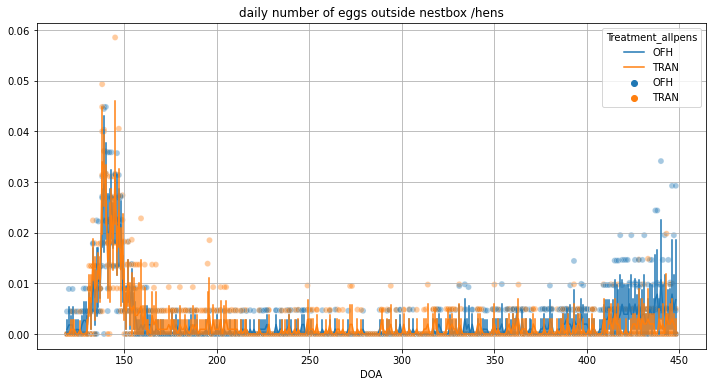

2,Datum,Vers.-Tag,Ab-gänge,Kanni-balis.,spez. Veränderung,Anfangs-Bestand,Tier-bestand,ver-legt,Nest-eier,Total,...,#eggPerTier,#eggOutsideBoxPerTier,Early_death,DOA,WOA,DIB,WIB,level,Treatment,Treatment_allpens
4,2020-09-24 00:00:00,1,0,0,NaN,225,225,NaN,NaN,0,...,0.0,0.0,0.0,113,17,-5,0,2020-09-24,OFH,OFH
5,2020-09-25 00:00:00,2,0,0,NaN,225,225,NaN,NaN,0,...,0.0,0.0,0.0,114,17,-4,0,2020-09-25,OFH,OFH


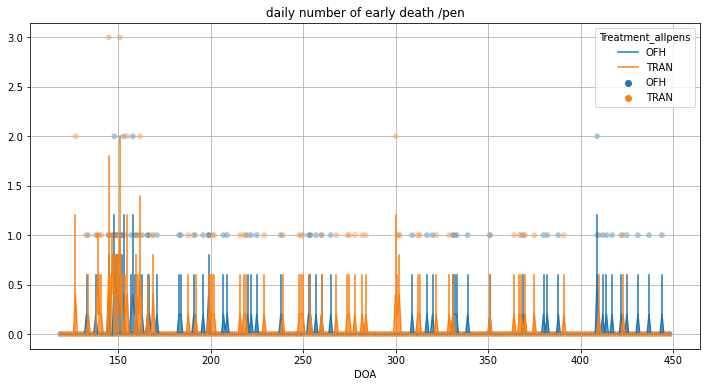

In [32]:
for v in ['#eggPerTier', '#eggOutsideBoxPerTier', 'Early_death']:
    plt.figure(figsize=(12,6))
    plt.grid()
    ax = plt.plot()
    df_treatment[v] = df_treatment[v].astype(float)
    display(df.head(2))
    sns.lineplot(x="DOA", y=v, data=df_treatment, hue='Treatment_allpens', estimator=np.mean, err_style="bars", ci=95, color='black');
    sns.scatterplot(x="DOA", y=v, data=df_treatment, hue='Treatment_allpens', alpha=0.4, color='grey');
    plt.ylabel('')
    plt.title(dico_title[v])
    plt.savefig(os.path.join(path_performance_visual,v+'_DOA_treatment.png'),dpi=300,format='png',bbox_inches='tight')
    plt.show();

2,Datum,Vers.-Tag,Ab-gänge,Kanni-balis.,spez. Veränderung,Anfangs-Bestand,Tier-bestand,ver-legt,Nest-eier,Total,...,#eggPerTier,#eggOutsideBoxPerTier,Early_death,DOA,WOA,DIB,WIB,level,Treatment,Treatment_allpens
4,2020-09-24 00:00:00,1,0,0,NaN,225,225,NaN,NaN,0,...,0.0,0.0,0.0,113,17,-5,0,2020-09-24,OFH,OFH
5,2020-09-25 00:00:00,2,0,0,NaN,225,225,NaN,NaN,0,...,0.0,0.0,0.0,114,17,-4,0,2020-09-25,OFH,OFH


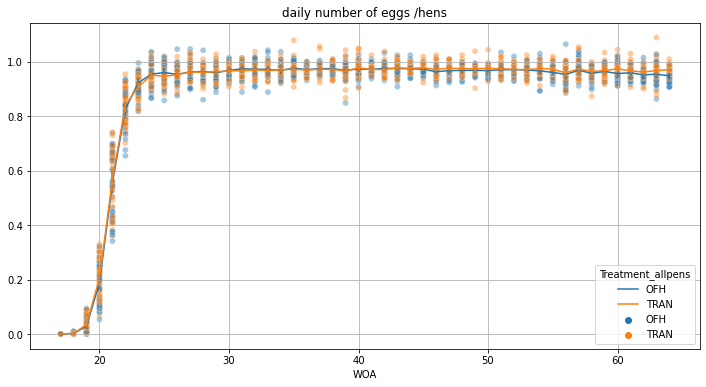

2,Datum,Vers.-Tag,Ab-gänge,Kanni-balis.,spez. Veränderung,Anfangs-Bestand,Tier-bestand,ver-legt,Nest-eier,Total,...,#eggPerTier,#eggOutsideBoxPerTier,Early_death,DOA,WOA,DIB,WIB,level,Treatment,Treatment_allpens
4,2020-09-24 00:00:00,1,0,0,NaN,225,225,NaN,NaN,0,...,0.0,0.0,0.0,113,17,-5,0,2020-09-24,OFH,OFH
5,2020-09-25 00:00:00,2,0,0,NaN,225,225,NaN,NaN,0,...,0.0,0.0,0.0,114,17,-4,0,2020-09-25,OFH,OFH


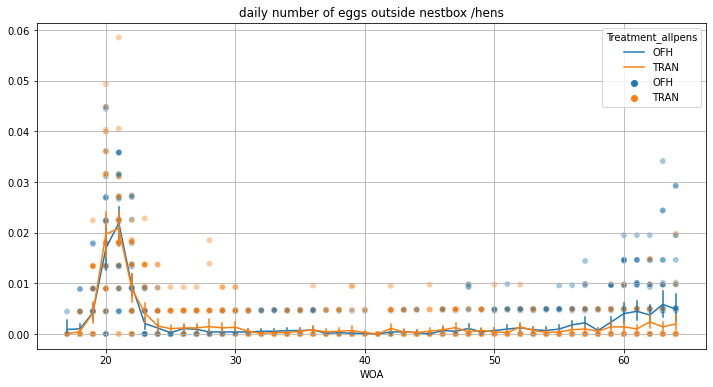

2,Datum,Vers.-Tag,Ab-gänge,Kanni-balis.,spez. Veränderung,Anfangs-Bestand,Tier-bestand,ver-legt,Nest-eier,Total,...,#eggPerTier,#eggOutsideBoxPerTier,Early_death,DOA,WOA,DIB,WIB,level,Treatment,Treatment_allpens
4,2020-09-24 00:00:00,1,0,0,NaN,225,225,NaN,NaN,0,...,0.0,0.0,0.0,113,17,-5,0,2020-09-24,OFH,OFH
5,2020-09-25 00:00:00,2,0,0,NaN,225,225,NaN,NaN,0,...,0.0,0.0,0.0,114,17,-4,0,2020-09-25,OFH,OFH


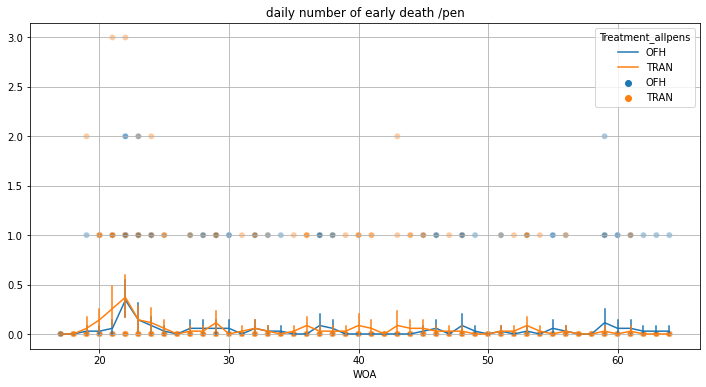

In [33]:
for v in ['#eggPerTier', '#eggOutsideBoxPerTier', 'Early_death']:
    plt.figure(figsize=(12,6))
    plt.grid()
    ax = plt.plot()
    df_treatment[v] = df_treatment[v].astype(float)
    display(df.head(2))
    sns.lineplot(x="WOA", y=v, data=df_treatment, hue='Treatment_allpens', estimator=np.mean, err_style="bars", ci=95, color='black');
    sns.scatterplot(x="WOA", y=v, data=df_treatment, hue='Treatment_allpens', alpha=0.4, color='grey');
    plt.ylabel('')
    plt.title(dico_title[v])
    plt.savefig(os.path.join(path_performance_visual,v+'_WOA_treatment.png'),dpi=300,format='png',bbox_inches='tight')
    plt.show();

## Death

In [34]:
#look more precisely when they occured
df_treatment[df_treatment['Early_death']>0][['Datum','PenID','Treatment','Early_death','DOA']].sort_values(['DOA'])

2,Datum,PenID,Treatment,Early_death,DOA
162,2020-10-08 00:00:00,10,TRAN,2.0,127
14,2020-10-14 00:00:00,3,OFH,1.0,133
213,2020-10-15 00:00:00,12,TRAN,1.0,134
19,2020-10-19 00:00:00,3,OFH,1.0,138
130,2020-10-20 00:00:00,8,TRAN,1.0,139
...,...,...,...,...,...
3274,2021-07-31 00:00:00,12,TRAN,1.0,423
3024,2021-08-02 00:00:00,3,OFH,1.0,425
3086,2021-08-08 00:00:00,5,OFH,1.0,431
3036,2021-08-14 00:00:00,3,OFH,1.0,437


(1320, 3)


,DOA,Treatment,Early_death
0,119,OFH,0.0
1,119,OFH-nonfocal,0.0
2,119,TRAN,0.0


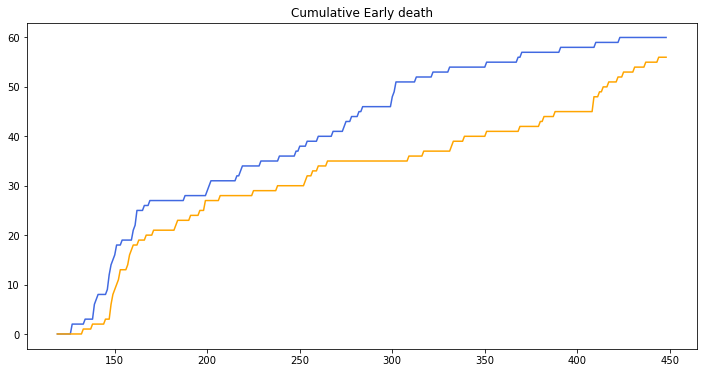

(1320, 3)


,DOA,Treatment,#eggOutsideBoxPerTier
0,119,OFH,0.004444
1,119,OFH-nonfocal,0.000000
2,119,TRAN,0.000000


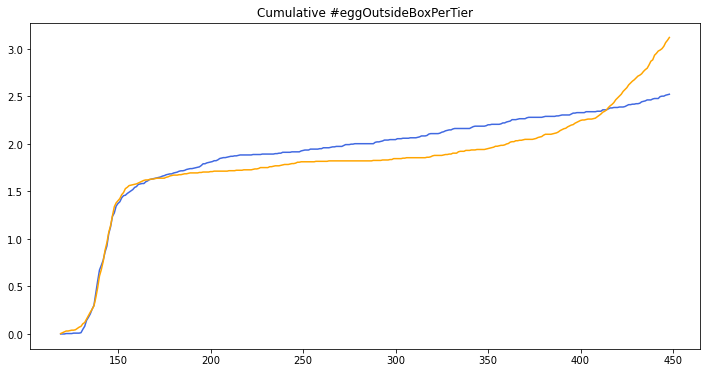

In [35]:
for v in ['Early_death','#eggOutsideBoxPerTier']:
    
    df_= df_treatment.groupby(['DOA','Treatment'])[v].sum().reset_index()
    print(df_.shape)
    display(df_.head(3))

    #plot
    plt.figure(figsize=(12,6))
    ax = plt.plot()
    df_[v] = df_[v].astype(float)
    #Cumulative Variance explains
    #TRAN
    x_TRAN = df_[df_['Treatment']=='TRAN']['DOA'].tolist()
    li_TRAN = np.cumsum(df_[df_['Treatment']=='TRAN'][v].tolist())
    plt.plot(x_TRAN, li_TRAN, color='royalblue')
    #OFH
    x_OFH = df_[df_['Treatment']=='OFH']['DOA'].tolist()
    li_OFH = np.cumsum(df_[df_['Treatment']=='OFH'][v].tolist())
    plt.plot(x_OFH, li_OFH, color='orange')
    plt.title('Cumulative '+v.replace('_',' '))
    plt.savefig(os.path.join(path_performance_visual, 'Cumulative_'+v+'_DOA_treatment.png'),dpi=300,format='png',bbox_inches='tight')
    plt.show();

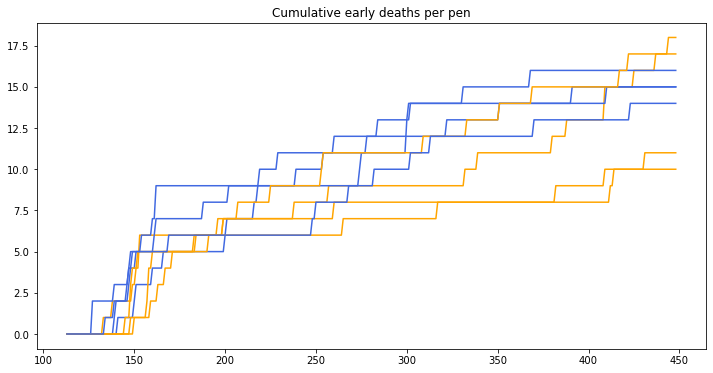

In [36]:
#per pen
plt.figure(figsize=(12,6))
ax = plt.plot()
for p in df['PenID'].unique():
    df_= df[df['PenID']==p].groupby(['DOA','Treatment'])['Early_death'].sum().reset_index()

    #plot the cumulative early death
    #TRAN
    x_TRAN = df_[df_['Treatment']=='TRAN']['DOA'].tolist()
    li_TRAN = np.cumsum(df_[df_['Treatment']=='TRAN']['Early_death'].tolist())
    plt.plot(x_TRAN, li_TRAN, color='royalblue')
    #OFH
    x_OFH = df_[df_['Treatment']=='OFH']['DOA'].tolist()
    li_OFH = np.cumsum(df_[df_['Treatment']=='OFH']['Early_death'].tolist())
    plt.plot(x_OFH, li_OFH, color='orange')
    plt.title('Cumulative early deaths per pen')
    plt.savefig(os.path.join(path_performance_visual, 'Pens_cum_Early_death_DOA_treatment.png'),dpi=300,format='png',bbox_inches='tight')
plt.show();